In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import numpy as np
import dask.array as da
from dask import delayed, compute
from numba import njit

ModuleNotFoundError: No module named 'dask'

Original question: https://mathematica.stackexchange.com/questions/95358/how-can-i-use-mathematica-to-solve-a-stefan-problem-using-an-explicit-scheme

Prompt for Microsoft Copilot: hey can you write this in python and numpy (copy paste Mathematica code)

In [ ]:
soil_depth = 1.0
ngridpoints = 100
delta_x = soil_depth / ngridpoints

In [ ]:
flow_speed = 1e-2

curvature = 8e-5
x_topo = np.linspace(1,1000,100)
y_topo = -curvature * x_topo**2 - 0.02 *x_topo + 100
# y_topo = -1/2500 * (x_topo - 500)**2 + 100
# slope = np.arctan(2 * curvature * x_topo - 0.02)
# slope = np.arctan(-1*np.gradient(y_topo,x_topo))
slope = np.arctan(np.deg2rad(np.arange(0,90,2.5)))

In [ ]:
# Q = 0


# Q_paper = 1e2
# Q = (Q_paper * 0.001) / delta_x # turn it into kilojoules per second, and also m2 instead of m3? 

Q_rushlow = 13.2
# Q = (Q_rushlow * 0.001) # turn it into kilojoules per second, 

rho_w = 1000
g = 9.8
Q_calc = (flow_speed * rho_w * g * slope)
Q_values = Q_calc * 0.001


In [6]:
# Define the parameters
mean_temp = 0  # Mean annual temperature in Celsius
amplitude = 15  # Annual temperature amplitude in Celsius
period = 365 * 24 * 60 * 60  # Period of one year in seconds

delta_x = 1.0 / 100
tmax = 525600 * 60
ntpoints = round(tmax / 100)
ntdatapoints = 50

air_temp_time = np.linspace(0, period, num=ntpoints+1)
air_temperature = mean_temp + amplitude * np.sin(2 * np.pi * (air_temp_time-(120*60*60*24)) / period)


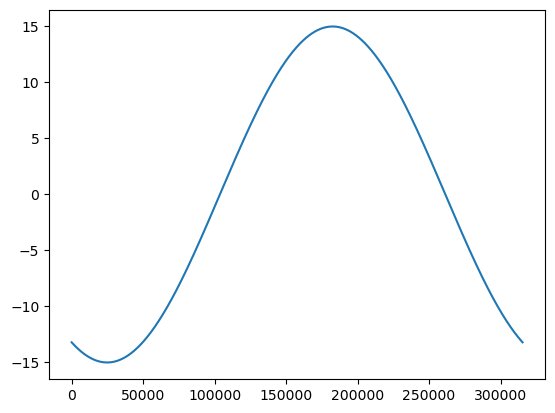

In [7]:
plt.plot(air_temperature)

In [8]:
@njit
def temp_function(enth, Tm, rho, cs, cl, L):
    return Tm + np.where(enth <= 0, enth / (rho * cs), 
                         np.where(enth < rho * L, 0, 
                                  (enth - rho * L) / (rho * cl)))

@njit
def delta_enth_func(temp, delta_x, delta_t, ks, kl, Tm, Q):
    klist = np.where(temp < Tm, ks, kl)
    qminus = -((temp - np.roll(temp, 1)) / (0.5 * delta_x * (1 / klist + 1 / np.roll(klist, 1))))[1:-1]
    qplus = -((np.roll(temp, -1) - temp) / (0.5 * delta_x * (1 / klist + 1 / np.roll(klist, -1))))[1:-1]
    return np.where(temp[1:-1] < Tm,
                     (delta_t / delta_x *  (qminus - qplus)),
                     (delta_t / delta_x *  (qminus - qplus)) + (Q * np.ones_like(temp[1:-1]) * delta_t))

@njit
def temperature_list_withQ(Tinitial, Tsource, delta_t, tfinal, soil_depth, ngridpoints, period, mean_temp, amplitude, Q):
    L = 333.73
    ks = 0.00266
    kl = 0.0012
    cs = 1.915
    cl = 3.835
    rho = 1070
    Tm = 0

    delta_x = soil_depth / ngridpoints
    tmax = tfinal * 60
    ntpoints = round(tmax / delta_t)
    ntdatapoints = 50

    air_temp_time = np.linspace(0, period, num=ntpoints+1)
    air_temperature = mean_temp + amplitude * np.sin(2 * np.pi * (air_temp_time-(120*60*60*24)) / period)

    temperature = np.full(ngridpoints, Tinitial)
    temperature[0] = Tsource
    enthalpy = np.full(ngridpoints - 2, rho * cl * (Tinitial - Tm) + rho * L if Tinitial > Tm else rho * cs * (Tinitial - Tm))

    templist = np.empty((ntdatapoints, ngridpoints))
    airtemp_list = []
    for n in range(ntpoints + 1):
        temperature[0] = air_temperature[n]
        
        temperature[1:-1] = temp_function(enthalpy, Tm, rho, cs, cl, L)
        enthalpy += delta_enth_func(temperature, delta_x, delta_t, ks, kl, Tm, Q)
        if (n - 1) % round(ntpoints / ntdatapoints) == 0:
            templist[(n - 1) // round(ntpoints / ntdatapoints)] = temperature.copy()
            airtemp_list.append(air_temperature[n])

    return templist, airtemp_list

In [9]:
@delayed
def calculate_temperature_list(Q):
    Tinitial = -7.
    Tsource = -5.
    delta_t = 10.0
    tfinal = 525600
    soil_depth = 1.0
    ngridpoints = 100
    period = 31536000
    mean_temp = 0
    amplitude = 15
    return temperature_list_withQ(Tinitial, Tsource, delta_t, tfinal, soil_depth, ngridpoints, period, mean_temp, amplitude, Q)

In [10]:
delayed_tasks = []
for i, Q in enumerate(Q_values):
    delayed_task = delayed(calculate_temperature_list)(Q)
    delayed_tasks.append(delayed_task)

# Execute the delayed tasks in parallel
results = compute(*delayed_tasks, num_workers=len(delayed_tasks))

In [11]:
Tinitial = -7.
Tsource = -5.
delta_t = 10.0
tfinal = 525600
soil_depth = 1.0
ngridpoints = 100
period = 31536000
mean_temp = 0
amplitude = 15
results_noq = temperature_list_withQ(Tinitial, Tsource, delta_t, tfinal, soil_depth, ngridpoints, period, mean_temp, amplitude, 0)

(100.0, 0.0)

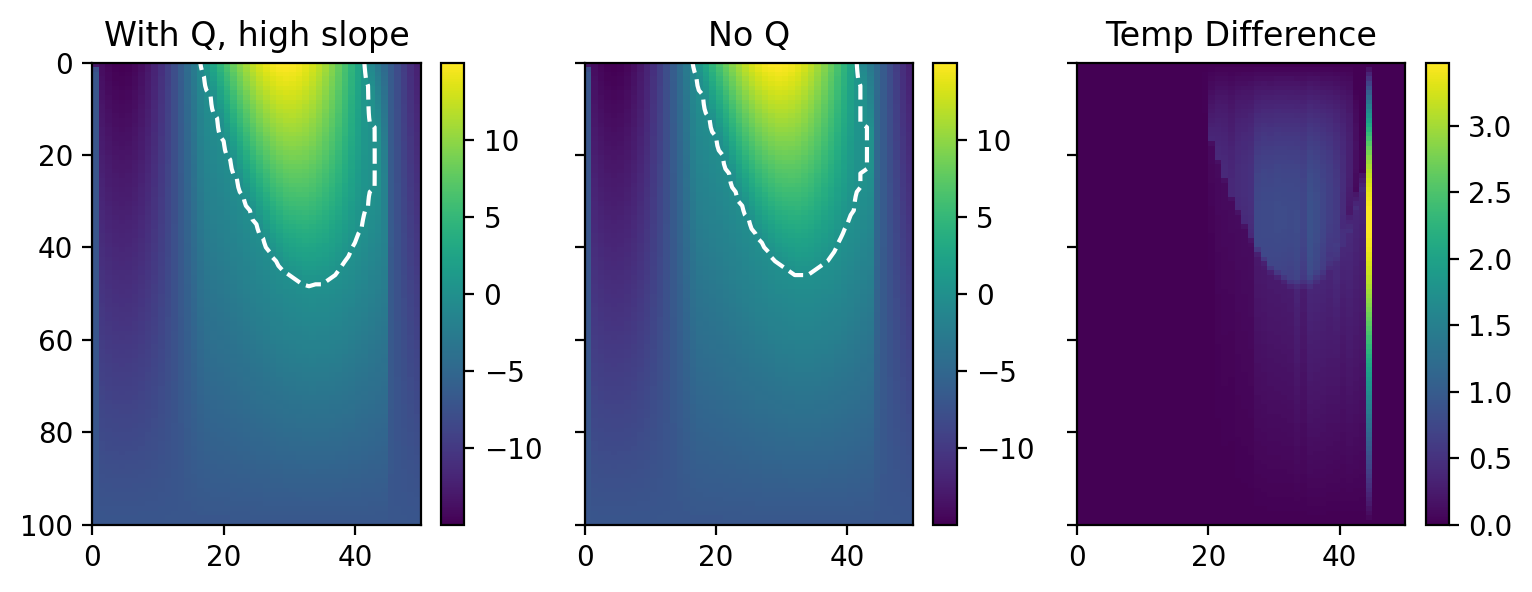

In [42]:
plt_index=-1
fig, ax = plt.subplots(1,3, figsize=(9,3),sharey=True,dpi=200)
im = ax[0].pcolormesh(

    results[plt_index][0].T
    )
plt.colorbar(im)
CS1 = ax[0].contour(
                    

                    results[plt_index][0].T, [0],  colors='white', linestyles='--'
                    )

im = ax[1].pcolormesh(

    results_noq[0].T,
    )
plt.colorbar(im)
CS1 = ax[1].contour(
                    

                    results_noq[0].T, [0],  colors='white', linestyles='--'
                    )

im = ax[2].pcolormesh(

    results[plt_index][0].T-results_noq[0].T
    )
plt.colorbar(im)

ax[0].set_title('With Q, high slope')
ax[1].set_title('No Q')
ax[2].set_title('Temp Difference')

ax[1].set_ylim(100,0)

In [13]:
def deepest_temp_above_zero(temperature_array):
    max_depth = -1
    for col in range(temperature_array.shape[1]):
        for row in range(temperature_array.shape[0] - 1):
            if temperature_array[row, col] > 0 and temperature_array[row + 1, col] <= 0:
                max_depth = max(max_depth, row)
                break
    return max_depth

max_depth = [deepest_temp_above_zero(results[i][0].T) for i, res in enumerate(results)]


Text(0.5, 0, 'Distance (m)')

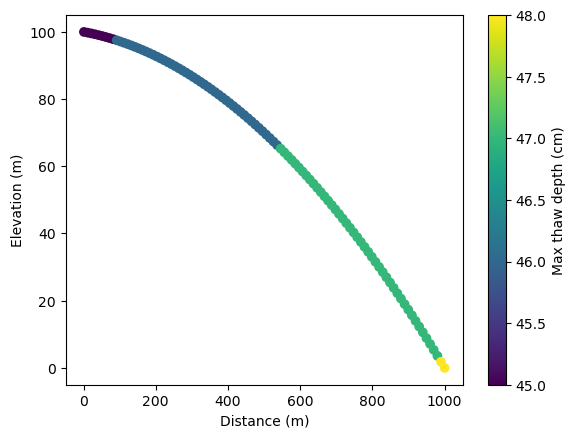

In [16]:
fig, ax = plt.subplots()
ax.plot(x_topo,y_topo, c='gray',zorder=0)
im = ax.scatter(x_topo,y_topo, c=np.array(max_depth),zorder=1 )
plt.colorbar(im, label='Max thaw depth (cm)')
ax.set_ylabel('Elevation (m)')
ax.set_xlabel('Distance (m)')

Text(0, 0.5, 'max thaw depth over the season')

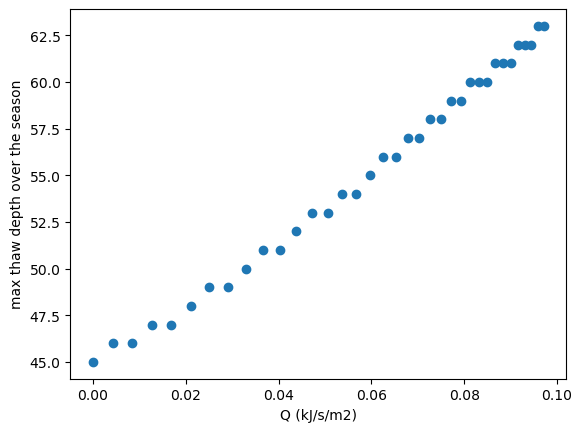

In [16]:
fig, ax = plt.subplots()
ax.scatter(Q_values,np.array(max_depth),zorder=1 )
ax.set_xlabel('Q (kJ/s/m2)')
ax.set_ylabel('max thaw depth over the season')

In [44]:
np.rad2deg(slope[-1])

10.159165680492851